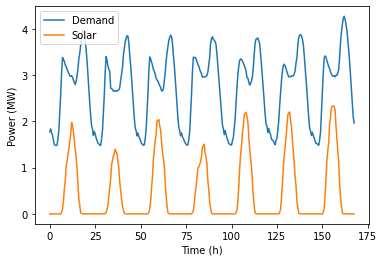

In [1]:
#%%%% Get the week's forecasts for solar and demand, formatted as 7 x array(size=48) each!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel (r'/Users/cormacomalley/Documents/POD_Challenge/week1-pv.xlsx') #place "r" before the path string to address special character, such as '\'. Don't forget to put the file name at the end of the path + '.xlsx'
WeekSolar=df.to_numpy()[:,1]

df = pd.read_excel (r'/Users/cormacomalley/Documents/POD_Challenge/week1-demand.xlsx') #place "r" before the path string to address special character, such as '\'. Don't forget to put the file name at the end of the path + '.xlsx'
WeekDemand=df.to_numpy()[:,1]

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(np.arange(0,168,0.5), WeekDemand,label='Demand')  # Plot Demand forecast
ax.plot(np.arange(0,168,0.5), WeekSolar,label='Solar')  # Plot Solar forecast

ax.legend(loc='upper left')
plt.xlabel("Time (h)")
plt.ylabel("Power (MW)")

#seperate the forecasts into individual days, 0 is Monday, 6 is sunday
DayDemand=np.empty([7,48])
DaySolar=np.empty([7,48])

for d in range(0,7):
    DayDemand[d,:]=WeekDemand[(d*48):(d+1)*48]
    DaySolar[d,:]=WeekSolar[(d*48):(d+1)*48]

In [11]:
#%%%% Deterministic solving of the optimal charging problem %%%%#

import pyomo.environ as pyo
from pyomo.opt import SolverFactory

# Create a solver
opt = pyo.SolverFactory('mosek')

#create arrays to store variables for each day
B_day_results=np.empty([7,48]) #stores optimal battery charging levels (MW)
C_day_results=np.empty([7,48]) #stores optimal battery charge levels (MWh) (NB C orresponds to charge at the beginning of k timestep)
ReducedDemand=np.empty([7,48]) #the demand net battery discharge (MW)

Day_Peak_Reduction=np.empty([7]) #stores the peak reduction percentage (%)
Charge_Con_Factor=np.empty([7]) #stores the optimum Charge Conservativness Factor


for d in range(0,7):

    #%%%% Create model
    model=pyo.ConcreteModel()  #create the model object, concrete because parameters are known


    #%%%% Declare Indexs
    model.TimeIndex=range(48)  #NB, index for time of day, starts at 0 (referring to period 00:00 - 00:30)



    #%%%% Declare Parameters
    Conservativness_factor_limit = 0.9 #this limits the battery charge as a proportion of solar power (B[k] < Conservativness_factor*DaySolaa[k])

    ChargePeriodEnd = 30 #k index of final half hour time slot where charging is allowed (3:00pm-3:30pm), midnight k=0
    PeakPeriodEnd = 41 #k index of final half hour period of peak demand (8:30pm-9:00pm), midnight k = 0

    MaxBatteryChargeRate = 2.5 #Max charge and discharge rate in MW. Discharge -ive, Charge +ve
    MaxBatteryCapacity = 6 #Max Charge held in battery (MWh)

    #NB this is in MW
    Peak_old = sum(DayDemand[d,k] for k in range(ChargePeriodEnd+1,PeakPeriodEnd+1)) #this is the sum of peak demand with no battery (MW)
    model.Peak_old = pyo.Param(initialize = Peak_old)



    #%%%% Declare decision variables
    model.B=pyo.Var(model.TimeIndex, bounds = (-MaxBatteryChargeRate,MaxBatteryChargeRate)) #charging rate, discharge is -ve, charge is +ve 
    model.C=pyo.Var(model.TimeIndex, bounds = (0,MaxBatteryCapacity)) #this is the battery charge (MWh) at teh Beginning of the time period k
    model.Peak_new=pyo.Var() #sum of peak demand with charging
    model.Peak_reduction_percentage=pyo.Var() #percentage deduction in peak power demand
    model.conservativness_factor=pyo.Var( bounds = (0,Conservativness_factor_limit)) #assume is uniform over day for now, cannot be larger than Conservativness_factor_limit
    model.conservativness_factor_discharge=pyo.Var( bounds = (0,10)) #want to distribute the discharge evenly across peak period to prevent the 



    #%%%% Declare constraints
    #prevent battery discharge before peak time
    model.pos_charge_con = pyo.ConstraintList()
    for k in range(0,ChargePeriodEnd+1):   #the +1 is because range does not include the final entry
        model.pos_charge_con.add(model.B[k]>=0)

    #prevent battery charge during from beginning of peak period to end of day (3:30pm-11:59pm)   
    model.neg_charge_con = pyo.ConstraintList()
    for k in range(ChargePeriodEnd+1,48):
        model.neg_charge_con.add(model.B[k]<=0)

    #charge rate determines battery charge
    model.battery_charge_level_con = pyo.ConstraintList()
    for k in range(0,48):
        if k==0:
            #model.battery_charge_level_con.add(model.C[k]==0.5*model.B[k]) #battery starts on zero charge
            model.battery_charge_level_con.add(model.C[k]==0) #battery starts on zero charge
        else:
            model.battery_charge_level_con.add(model.C[k]==model.C[k-1]+0.5*model.B[k-1])

    #battery charge must be zero at the end of the day (here i have constrained it to be zero at 11:30, as any time after peak suffices)
    model.end_of_day_charge = pyo.Constraint(expr = model.C[47] == 0)

    #Work out the new sum of peak demand (MW)
    model.Peak_new_con = pyo.Constraint(expr = model.Peak_new == sum(DayDemand[d,k]+model.B[k] for k in range(ChargePeriodEnd+1,PeakPeriodEnd+1)))
    #Define Peak reduction percentage
    model.Peak_reduction_percentage_con = pyo.Constraint(expr = 100*(model.Peak_old - model.Peak_new)*1/model.Peak_old == model.Peak_reduction_percentage)



    #%%% Add constraint to make discharge lower than the demand 
    #this spreads discharge evenly over peak period, the factor will approx=peakreductionpercentage/100
    model.solar_discharge_priority_con = pyo.ConstraintList()
    for k in range(ChargePeriodEnd+1,PeakPeriodEnd+1):   #the +1 is because range dis up to the final entry, but not including the final entry
        model.solar_discharge_priority_con.add(-model.B[k]<=model.conservativness_factor_discharge*DayDemand[d,k])



    #%%%% Constraints to Improve Ratio of Solar Power in the Battery
    #to do this battery will charge with lowest conservativness factor possible for the battery to be entirely full
    model.solar_charge_priority_con = pyo.ConstraintList()
    for k in range(0,ChargePeriodEnd+1):   #the +1 is because range does not include the final entry
        model.solar_charge_priority_con.add(model.B[k]<=model.conservativness_factor*DaySolar[d,k])



    #%%%% Declare objective function
    #the conservativness factors are included as a penalty in the objective function to make them be as small as
    #possible without significantly impacting the peak reduction percentage
    model.obj=pyo.Objective(
        #expr=model.Peak_reduction_percentage-0.001*sum(model.C[k] for k in model.TimeIndex), 
        expr=model.Peak_reduction_percentage-0.001*model.conservativness_factor-0.001*model.conservativness_factor_discharge,
        sense=pyo.maximize )


    #%%%% Solve and store variables
    opt.solve(model) 
    
    for k in range(0,48):
        B_day_results[d,k]=pyo.value(model.B[k])
        C_day_results[d,k]=pyo.value(model.C[k])
        
    ReducedDemand[d,0:(ChargePeriodEnd+1)]=DayDemand[d,0:(ChargePeriodEnd+1)]
    ReducedDemand[d,(ChargePeriodEnd+1):48]=DayDemand[d,(ChargePeriodEnd+1):48]+B_day_results[d,(ChargePeriodEnd+1):48]

    Day_Peak_Reduction[d]= pyo.value(model.Peak_reduction_percentage)#stores the peak reduction percentage (%)
    Charge_Con_Factor[d]= pyo.value(model.conservativness_factor) #stores the optimum Charge Conservativness Factor


#%%%% Display Results
#model.display()


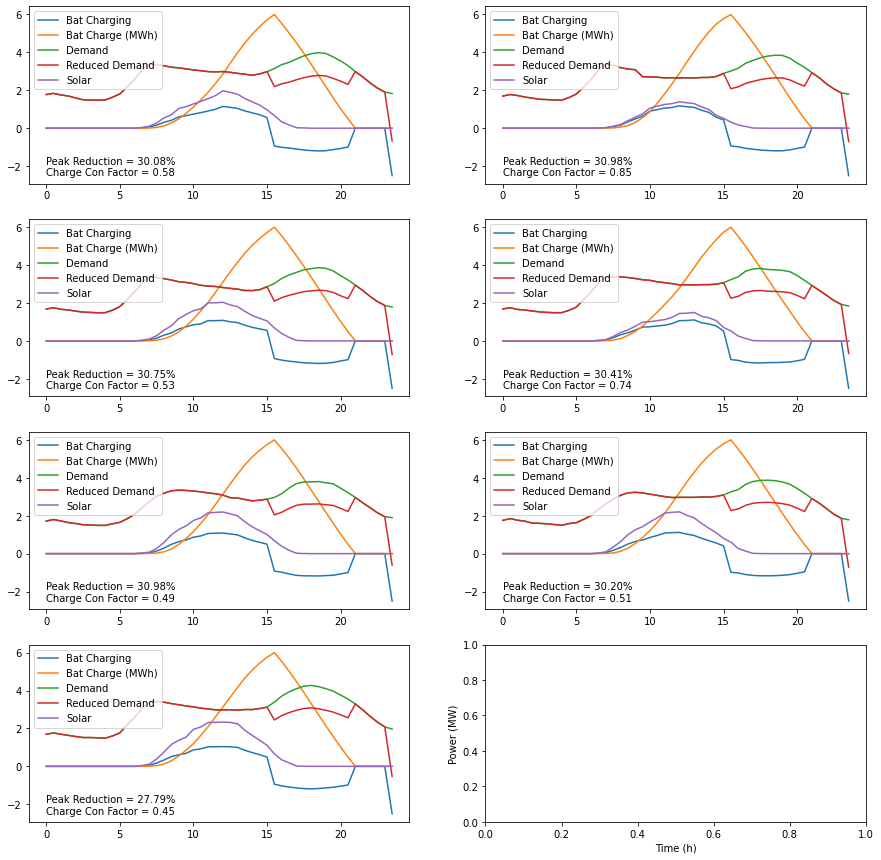

In [12]:
#%%%% Plot Results %%%%#

import matplotlib.pyplot as plt

fig, ax = plt.subplots(4,2)  # Create a figure that has one axes per day

plotcolumn=0
plotrow=0
for d in range(0,7):
    
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), B_day_results[d,:], label='Bat Charging')  # Plot Battery Charging (+ve charge, -ve discharge)
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), C_day_results[d,:], label='Bat Charge (MWh)')  # Plot Battery Charge level (this is the charge at the end of the given timestep)
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), DayDemand[d,:],label='Demand')  # Plot Demand forecast
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), ReducedDemand[d,:],label='Reduced Demand')  # Plot adjusted Demand
    ax[plotrow,plotcolumn].plot(np.arange(0,24,0.5), DaySolar[d,:],label='Solar')  # Plot Solar forecast


    ax[plotrow,plotcolumn].legend(loc='upper left')
    plt.xlabel("Time (h)")
    plt.ylabel("Power (MW)")

    Notation = "Peak Reduction = "+"{:.2f}".format(Day_Peak_Reduction[d])+"%\nCharge Con Factor = " + "{:.2f}".format(Charge_Con_Factor[d])
    ax[plotrow,plotcolumn].annotate(Notation ,(0,min(B_day_results[d,:])))

    #if statements used to arrange the graphs correctly
    if d==1 or d==3 or d==5:
        plotrow += 1
    
    if plotcolumn==0:
        plotcolumn = 1
    else:
        plotcolumn = 0
       

fig.set_figheight(15)
fig.set_figwidth(15)       

In [13]:
df = pd.DataFrame(B_day_results).T
df.to_excel(excel_writer = r'/Users/cormacomalley/Documents/POD_Challenge/batterycharging.xlsx')

#r'/Users/cormacomalley/Documents/POD_Challenge/week1-demand.xlsx'

In [152]:
df = pd.DataFrame(C_day_results).T
df.to_excel(excel_writer = r'/Users/cormacomalley/Documents/POD_Challenge/batterychargelevel.xlsx')

In [14]:
print(B_day_results)

[[ 6.47490958e-05  6.29858810e-05  6.29858810e-05  6.29858810e-05
   6.29858810e-05  6.29858810e-05  6.29858810e-05  6.29858810e-05
   6.29858810e-05  7.34905528e-05  7.34905528e-05  1.11956513e-04
   1.15403634e-04  2.18551218e-02  6.09683776e-02  1.59179571e-01
   3.13689175e-01  4.15071211e-01  6.02078922e-01  6.62234655e-01
   7.46601886e-01  8.20521205e-01  9.09300756e-01  1.00014834e+00
   1.14971246e+00  1.10083582e+00  1.04272495e+00  9.12156422e-01
   8.07821728e-01  7.11987397e-01  5.62169018e-01 -9.45573868e-01
  -1.00868658e+00 -1.04484375e+00 -1.09874240e+00 -1.14641448e+00
  -1.18108298e+00 -1.19805650e+00 -1.18538536e+00 -1.12963570e+00
  -1.06811984e+00 -9.93458540e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.50000000e+00]
 [ 9.15071876e-05  9.15071876e-05  9.40688223e-05  9.40688223e-05
   9.40688223e-05  9.40688223e-05  9.40688223e-05  9.40688223e-05
   9.40688223e-05  1.06768592e-04  1.06768592e-04  1.16920308e-04
   1.3933